In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct,idct
from math import log10, sqrt

In [2]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):                    
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [3]:
def RMSE(img,img1):
    return np.sqrt(((img-img1)**2).mean())

In [4]:
def keys(index):
    x,y=index[:2]
    if (x+y)%2:
        return (x+y,-y)
    else:
        return (x+y,y)

In [5]:
def quantization_matrix(n):
    
    std_matrix = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ], dtype=np.float32)

    
    resized_matrix = np.round(cv2.resize(std_matrix, (n, n), interpolation=cv2.INTER_LINEAR))

    return resized_matrix.astype(np.int16) 

In [6]:
def jpeg_encoder(img,block,parameters):
    count=0
    file=open("img_jpegcode.txt",'w')
    
    img_ycrcb=cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
    
    file.write("%s %s %s\n"%(img.shape[0],img.shape[1],block))
    i=0 
    
    while(i<img.shape[0]):
        j=0
        while(j<img.shape[1]):           
            
            for k in range(0,3):
                img1=np.zeros((block,block),dtype=np.int32)
                img1[0:img_ycrcb.shape[0]-i,0:img_ycrcb.shape[1]-j]=img_ycrcb[i:min(i+block,img_ycrcb.shape[0]),j:min(j+block,img_ycrcb.shape[1]),k]
                
                temp=np.ones((block,block),dtype='int')*(-128)
                img1=np.add(img1,temp)  
                
                img2=np.float32(img1)               
                
                # img2=dct(dct(img2.T, norm='ortho').T, norm='ortho')
                img2=cv2.dct(img2)
                
                
                quantised=np.asarray(np.round(np.divide(img2,quantization_matrix(block))),dtype=np.int32)
                
                indices=[(x,y)for x in range(block)for y in range(block)]  
                sorted_indices=sorted(indices,key=keys) 
                
                res=[quantised[n] for n in sorted_indices]  
                res=[int(s) for s in res]
                
                if parameters==-1:
                    res=np.trim_zeros(res,trim='b')
                else:                    
                    res=res[:parameters]    
                    
                res.append(0)            
                    
                for l in res:
                    file.write("%s "%l)
                    count+=1
                file.write("\n")  
            
            j+=block
    
        i+=block
        
    file.close()
    return (img.shape[0]*img.shape[1]*3)/count
    

In [7]:
def jpeg_decoder():
    file=open("img_jpegcode.txt",'r')
    line=file.readline()
    arr=line.split()
    
    h=int(arr[0])
    w=int(arr[1])
    block=int(arr[2])   
    
      
    img=np.zeros((h+(block-h%block)%block,w+(block-w%block)%block,3),dtype=np.int32)    
    i=0
    j=0
    while(1):
        line1=file.readline()
        if line1=='':
           break
        
        
        line2=file.readline()
        line3=file.readline()     
        
        
        arr=[[int(s) for s in line1.split()],[int(s) for s in line2.split()],[int(s) for s in line3.split()]]
        
        for m in range (0,3):            
            arr1=arr[m]
            
            res=np.zeros((block*block),dtype=np.int32)
            
            res[:len(arr1)-1]=arr1[:len(arr1)-1]
            
            img1=np.zeros((block,block),dtype=np.int32)
            
            indices=[(x,y)for x in range(block)for y in range(block)]  
            sorted_indices=sorted(indices,key=keys)
            
            for k in range(0,len(res)):
                # x,y=sorted_indices[k][:2]
                img1[sorted_indices[k]]=res[k]
            
            
            
            rev_quantised=np.multiply(img1,quantization_matrix(block))
            
            img2=np.float32(rev_quantised)     
                
            img2=cv2.idct(img2)
            # img2=idct(idct(img2.T, norm='ortho').T, norm='ortho')
            
                
            img2=np.asarray(img2,dtype=np.int32)
            
            temp=np.ones(img2.shape,dtype=np.int32)*(128)
            temp1=np.add(img2,temp)
            img[i:i+block,j:j+block,m]=temp1[:,:]
            
        
        j+=block
        if j>=img.shape[1]:
            i+=block
            j=0
        
        if i>=img.shape[0]:
            break
    
    
    img=np.asarray(img,dtype=np.uint8)
    img_bgr=cv2.cvtColor(img,cv2.COLOR_YUV2BGR) 
    img_final=img_bgr[:h,:w,:3]
    file.close()
    return img_final   
        
    

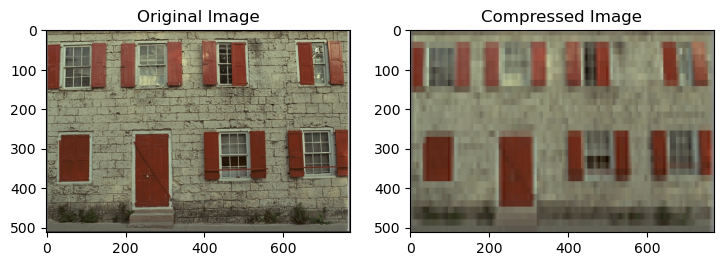

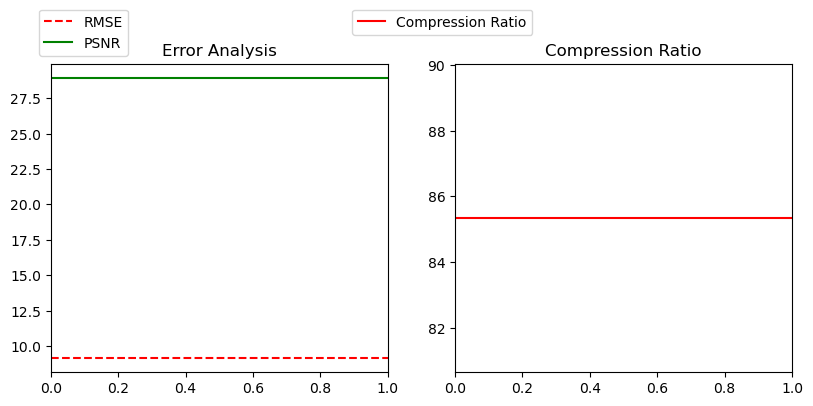

In [12]:
  
img=cv2.imread("test/kodim01.png",cv2.IMREAD_COLOR)
blocksize=16
coefficient_parameters=2


compression_ratio=jpeg_encoder(img,blocksize,coefficient_parameters)
compressed_img=jpeg_decoder()



psnr=PSNR(img,compressed_img)
rmse=RMSE(img,compressed_img)
        
        


plt.figure(figsize=[18,5])
plt.subplot(141);plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB));plt.title("Original Image")
plt.subplot(142);plt.imshow(cv2.cvtColor(compressed_img,cv2.COLOR_BGR2RGB));plt.title("Compressed Image")


plt.figure(figsize=[20,4])
plt.subplot(143);plt.title("Error Analysis")
plt.axhline(y=rmse,color='r',linestyle='dashed',label="RMSE")
plt.axhline(y=psnr,color='g',linestyle='-',label="PSNR")
plt.legend(bbox_to_anchor=(0.25, 1.20))

plt.subplot(144);plt.title("Compression Ratio")
plt.axhline(y=compression_ratio,color='r',linestyle='-',label="Compression Ratio")
plt.legend(bbox_to_anchor=(0.25, 1.20))

plt.show()
